## Aggregation File 

In this notebook we aggregate the key components of the analysis that we are interested in. They are not meant to be running consecutively, but rather to be used as a reference for the overall analysis that takes place. 

Here is a list of data sources used (or planned to be used) in this notebook:
- For Country shape files  [1](https://gadm.org/index.html)
-  For global population data [2](https://ghsl.jrc.ec.europa.eu/download.php?ds=pop)
- For spatially harmonized critical infrastructure data visit [3](https://zenodo.org/records/4957647)
- For gridded spatial deprivation index visit [4](https://sedac.ciesin.columbia.edu/data/set/povmap-grdi-v1)<br>
========================================================================
- For access to harmonized NTL visit [5](https://figshare.com/articles/dataset/Harmonization_of_DMSP_and_VIIRS_nighttime_light_data_from_1992-2018_at_the_global_scale/9828827/2?file=17626016)
- For access to global 1x1km GDP estimates visit [6](https://figshare.com/articles/dataset/Global_1_km_1_km_gridded_revised_real_gross_domestic_product_and_electricity_consumption_during_1992-2019_based_on_calibrated_nighttime_light_data/17004523/1?file=31456837)
- For access to global 1x1km electricity Consumption estimates visit [6](https://figshare.com/articles/dataset/Global_1_km_1_km_gridded_revised_real_gross_domestic_product_and_electricity_consumption_during_1992-2019_based_on_calibrated_nighttime_light_data/17004523/1?file=31456837)


Sources [3] and [4] are currently not included in the analysis. However they should be added similar to the population data as single datapoint for each grid cell through averaging/summing.
Similarly, sources [5] and electricity consumption of [6] should be added similar to the generated time series data for each cell of gdp.<br>




Before running make sure to activate the environment via the following command:<br>
<br>
REMARK: *(On my local machine i was not able to resolve a dependency issue with fiona in the virtual environment)*<br>

source myenv/bin/activate




In [3]:
# Import relevant packages
import numpy as np
import pandas as pd
import random
import PIL
import rasterio
import shapefile
import geopandas as gpd
import matplotlib.pyplot as plt
from PIL import Image
from pyproj import Transformer
from rasterio import features
from rasterio.enums import Resampling
from rasterio.mask import mask, raster_geometry_mask
from rasterio.plot import show
from shapely.geometry import Polygon, MultiPolygon, mapping
from skimage.measure import block_reduce
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm
from bridson import poisson_disc_samples
import matplotlib.patches as patches
import scienceplots 
import os 
import Tesselation as tess
import ipykernel


After importing the necessary libraries, we take a look at the tif files for NTL at different locations. 


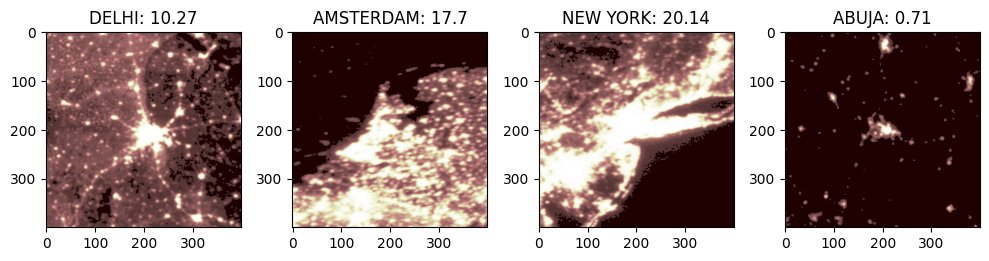

In [6]:
location_list = [
    ("Delhi", (28.7041, 77.1025)),
    ("Amsterdam", (52.3676, 4.9041)),
    ("New York", (40.7128, -74.006)),
    ("Abuja", (9.0765, 7.3986))
]

raster_file_path = '../Data_summary/NTL/Harmonized_DN_NTL_2008_calDMSP.tif'
tess.plot_geographic_snapshots(location_list, raster_file_path)
#this can be similarly extended to other datasets as well!


Next we determine the region of interest. Generally we are interested in the entire world, but for demonstration purposes we choose Belgium, the Netherlands and Germany. 


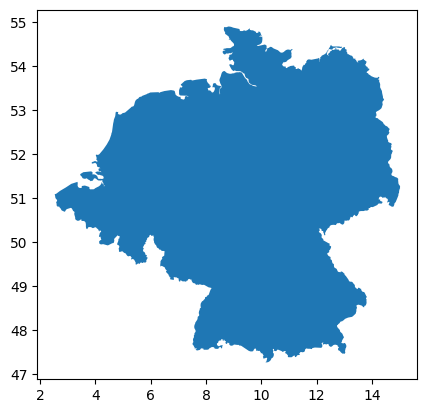

In [4]:

#Country code can be found in the folder "Data_summary/country_geometry" in the file "Country_codes.csv"
country_codes = ["NL1", "BEL", "DEU"]
#In the same folder we have the shapefiles for the countries as well
#Here we create a joint shape file out of the country list.
combined_geo_df = tess.get_combined_country_geometry(country_codes)
tess.visualize_geometry(combined_geo_df) 
#Save the population density of the combined countries
tess.get_pop_density_for_geodf(combined_geo_df)

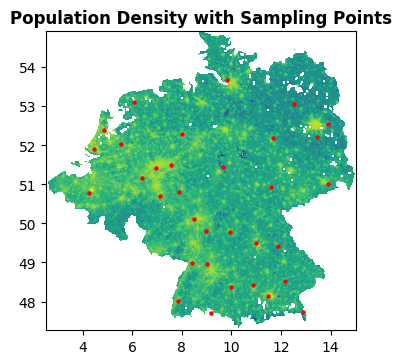

In [5]:
#Use Population density of selected region to sample points 
raster_path = '../Data_summary/POP/selection.tif'
probability_gdf = tess.raster_to_spatial_probability_distribution(raster_path, power=2)
points = tess.poisson_disk_sampling_with_geodf(probability_gdf, radius=0.5, n_samples=100)
# Visualize
tess.visualize_with_population(points, raster_path)

**Next we create tesselation for a given sample points of region using voronoi tessellation.**
#### Alternative gridding approaches still needed
- *uniform grid*
- *hierarchical grid*


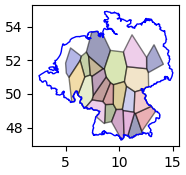

In [6]:
boundary =   combined_geo_df.geometry[0]
voronoi_gdf = tess.create_voronoi_gdf(points, boundary)
tess.visualize_voronoi(voronoi_gdf, boundary)

## Attributing Values to the Grids

Starting with Population we start creating time-series data with the available datasets. <br>
<br>
**Annually:**    GDP, Electricity Consumption <br>
**Once:**    Population, Deprivation Index, Aggricultural GDP, harmonized critical infrastructure.<br>

In [7]:
# Attribute values that have only one measurement over time

population_gdf = tess.raster_to_population_gdf(raster_path)
attributed_voronoi_gdf = tess.attribute_values_to_voronoi_cells(voronoi_gdf, population_gdf, 'population')

# Attribute values that have multiple mesuarements over time
# List of years to process
years = list(range(1993, 1995))
# Loop over each year to process GDP data
for year in years:
    raster_path = f'../Data_summary/GDP/{year}/{year}GDP.tif'
    output_raster_path = f'../Data_summary/POP/gdp_selection_{year}.tif'
    tess.selection_of_tif_for_geodf(combined_geo_df, raster_path, output_raster_path)
    gdp_gdf = tess.raster_to_gdf(output_raster_path, name=f'gdp_{year}')
    gdp_value_name = f'gdp_{year}'  # Dynamic column name for the GDP data

    attributed_voronoi_gdf = tess.attribute_values_to_voronoi_cells(attributed_voronoi_gdf, gdp_gdf, gdp_value_name)




/Users/mengeshi/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


Index(['geometry', 'index_right', 'population'], dtype='object')


/Users/mengeshi/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


Index(['geometry', 'population', 'index_right', 'gdp_1993'], dtype='object')


/Users/mengeshi/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


Index(['geometry', 'population', 'gdp_1993', 'index_right', 'gdp_1994'], dtype='object')


In [1]:
#save results in geodatatframe:
# They output file is located in the folder "Data_summary/Tessellation" in geojson format
tess.save_tessellation_data(points, attributed_voronoi_gdf)

#NOTE: The way the data is saved should include information about the parameters used to generate the data.
#NOTE: The goal is time seried data for each tesselation cell of the data of interest source [5] and [6]


NameError: name 'tess' is not defined

## Open Tasks:

- Implement two more gridding techniques
- Establish pipline for: 
    - for each gridding technique
        - for each sampling density
            - save multiple griddings with corresponding time-series data
- Parallelize the process
- download the data from the sources
- solve issue with border gridd cells by adding additional vertices

